**Abstract**

* KFold LightGBM regression works without "building_id".(score; 1.10)
* The importance of "site_id" cannot be high even though "building_id" is dropped.

**Data Preparation**

After cleaning data, drop "building_id".

In [1]:
import gc
import os
import random
import csv
import sys

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

path_data = "/kaggle/input/ashrae-energy-prediction/"
save_grid = "grid_search.csv"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

plt.style.use("seaborn")
sns.set(font_scale=1)

df_train = pd.read_csv(path_train)

building = pd.read_csv(path_building)
le = LabelEncoder()
building.primary_use = le.fit_transform(building.primary_use)

weather_train = pd.read_csv(path_weather_train)

df_train = reduce_mem_usage(df_train)
building = reduce_mem_usage(building)
weather_train = reduce_mem_usage(weather_train)

def prepare_data(X, building_data, weather_data, test=False):
    """
    Preparing final dataset with all features.
    """
    
    X = X.merge(building_data, on="building_id", how="left")
    X = X.merge(weather_data, on=["site_id", "timestamp"], how="left")
    
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.square_feet = np.log1p(X.square_feet)
    
    if not test:
        X.sort_values("timestamp", inplace=True)
        X.reset_index(drop=True, inplace=True)
    
    gc.collect()
    
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    X["is_holiday"] = (X.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
    
    drop_features = [ "sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count","cloud_coverage", "precip_depth_1_hr"]

    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        return X, y

X_train, y_train = prepare_data(df_train, building, weather_train)

del df_train, weather_train
gc.collect()

y_train = y_train[~((X_train.building_id <= 104) & (X_train.meter==0) & (X_train.timestamp<='2016-05-20'))]
X_train = X_train[~((X_train.building_id <= 104) & (X_train.meter==0) & (X_train.timestamp<='2016-05-20'))]
y_train = y_train[X_train.building_id != 1099]
X_train = X_train[X_train.building_id != 1099]
X_train.drop("timestamp", axis=1, inplace=True)
X_train.drop("building_id", axis=1, inplace=True)

df_test = pd.read_csv(path_test)
weather_test = pd.read_csv(path_weather_test)
df_test = reduce_mem_usage(df_test)
weather_test = reduce_mem_usage(weather_test)

X_test, row_ids = prepare_data(df_test, building, weather_test, test=True)
X_test.drop("timestamp", axis=1, inplace=True)
X_test.drop("building_id", axis=1, inplace=True)

nsplits = 3

folds = KFold(n_splits=nsplits)
categorical_features = ["site_id", "meter",  "hour", "weekday","primary_use"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "max_depth": -1,
    "num_leaves": 1000,
    "learning_rate": 0.1,
    "feature_fraction": 0.95,
    "reg_lambda": 2,
    "max_bin": 550,
    "metric": "rmse"
}

pred = np.zeros(len(X_test))



Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  0.02 Mb (74.9% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


**KFold LightGBM and feature Importance**

Here, we use KFold LightGBM(K = 3).
The most important feature is "square_feet".
I first thought that "site_id" might replace "building_id", but the importance of "site_id" is still low even after removing "building_id".


Building model with first half and validating on second half:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.808749	valid_1's rmse: 1.14262
Early stopping, best iteration is:
[90]	training's rmse: 0.815757	valid_1's rmse: 1.14185
Building model with first half and validating on second half:
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.840856	valid_1's rmse: 1.08573
[200]	training's rmse: 0.800036	valid_1's rmse: 1.08267
Early stopping, best iteration is:
[234]	training's rmse: 0.789288	valid_1's rmse: 1.08093
Building model with first half and validating on second half:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's rmse: 0.835527	valid_1's rmse: 1.16268


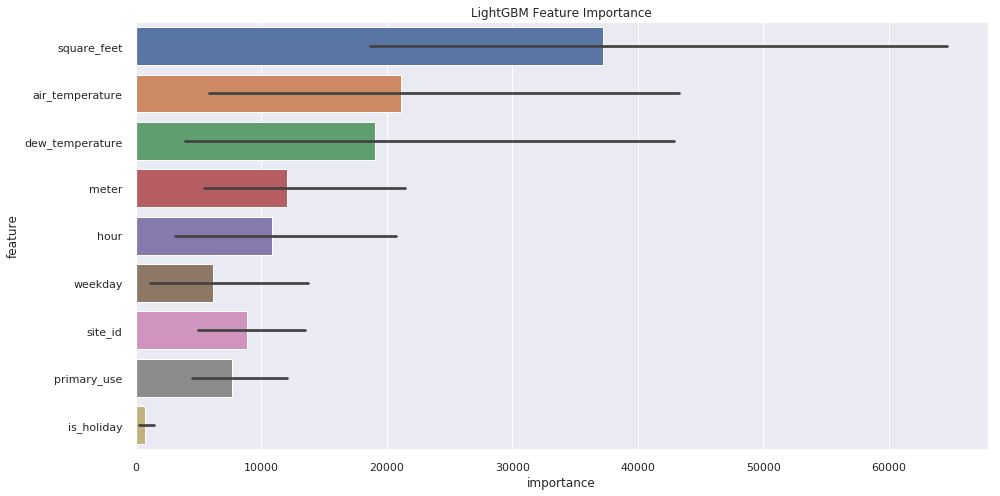

In [2]:
df_fimp = pd.DataFrame()
for tr_idx,va_idx in folds.split(X_train,y_train):
    X_half_1 = X_train.iloc[tr_idx]
    y_half_1 = y_train.iloc[tr_idx]
    X_half_2 = X_train.iloc[va_idx]
    y_half_2 = y_train.iloc[va_idx]

    d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
    d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

    print("Building model with first half and validating on second half:")
    model_half = lgb.train(params, train_set=d_half_1, num_boost_round=300, valid_sets=[d_half_1,d_half_2], verbose_eval=100, early_stopping_rounds=50)
    
    pred += np.expm1(model_half.predict(X_test, num_iteration=model_half.best_iteration)) / nsplits
    
    df_fimp_1 = pd.DataFrame()
    df_fimp_1["feature"] = X_train.columns.values
    df_fimp_1["importance"] = model_half.feature_importance()
    
    df_fimp = pd.concat([df_fimp, df_fimp_1], axis=0)
    del model_half
    gc.collect()

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

pred = pred*0.90
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv("submission.csv", index=False)